In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load a smaller VGG19 model
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg19.trainable = False

# Define content and style layers
CONTENT_LAYERS = ['block5_conv2']
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1']
CONTENT_LAYERS_COUNT = len(CONTENT_LAYERS)

In [2]:
# Function to compute gram matrix
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

# Function to extract features using VGG19
def extract_features(image, model):
    image = tf.keras.applications.vgg19.preprocess_input(image)
    outputs = [model.get_layer(name).output for name in STYLE_LAYERS + CONTENT_LAYERS]
    model = tf.keras.Model([vgg19.input], outputs)
    features = model(image)
    
    style_features = [gram_matrix(feature) for feature in features[:len(STYLE_LAYERS)]]
    content_features = features[len(STYLE_LAYERS):]
    
    return style_features, content_features

# Function to load and preprocess image
def load_and_preprocess_img(path, target_dim=256):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.resize(img, [target_dim, target_dim])
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]
    return img

In [3]:
# Optimization function
def run_style_transfer(content_path, style_path, num_iterations=500, content_weight=1e3, style_weight=1e-2):
    # Load images
    content_image = load_and_preprocess_img(content_path)
    style_image = load_and_preprocess_img(style_path)
    
    # Extract features from images
    style_features, content_features = extract_features(style_image, vgg19)
    
    # Initialize generated image
    init_image = tf.Variable(content_image)
    
    # Create optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
    
    # Optimization loop
    best_loss = float('inf')
    best_img = None
    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            style_features_gen, content_features_gen = extract_features(init_image, vgg19)
            
            # Compute loss
            content_loss = tf.add_n([tf.reduce_mean((content_features_gen[i] - content_features[i])**2) 
                                     for i in range(CONTENT_LAYERS_COUNT)])
            style_loss = tf.add_n([tf.reduce_mean((style_features_gen[i] - style_features[i])**2) 
                                   for i in range(len(STYLE_LAYERS))])
            
            total_loss = content_weight * content_loss + style_weight * style_loss
        
        # Compute gradients
        grads = tape.gradient(total_loss, init_image)
        
        # Update image
        optimizer.apply_gradients([(grads, init_image)])
        
        # Update best loss and image
        if total_loss < best_loss:
            best_loss = total_loss
            best_img = init_image.numpy()
        
        # Print progress
        if i % 100 == 0:
            print(f"Iteration {i+1}/{num_iterations} : Total Loss: {total_loss:.4e}, Style Loss: {style_loss:.4e}, Content Loss: {content_loss:.4e}")
    
    return best_img

Iteration 1/500 : Total Loss: 3.8817e+07, Style Loss: 3.7037e+09, Content Loss: 1.7802e+03
Iteration 101/500 : Total Loss: 1.4926e+06, Style Loss: 1.0832e+08, Content Loss: 4.0936e+02
Iteration 201/500 : Total Loss: 5.5561e+05, Style Loss: 3.8241e+07, Content Loss: 1.7320e+02
Iteration 301/500 : Total Loss: 2.7417e+05, Style Loss: 1.8256e+07, Content Loss: 9.1609e+01
Iteration 401/500 : Total Loss: 1.5110e+05, Style Loss: 9.8544e+06, Content Loss: 5.2556e+01


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


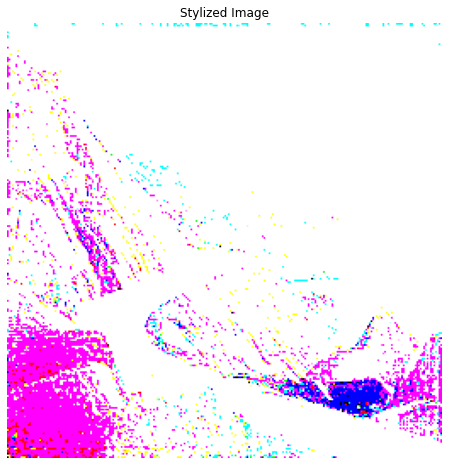

In [5]:
# Run style transfer
stylized_image = run_style_transfer('A.jpg', 'B.jpg')

# Display stylized image
plt.figure(figsize=(8, 8))
plt.imshow(np.squeeze(stylized_image))
plt.axis('off')
plt.title('Stylized Image')
plt.show()